In [5]:
%matplotlib inline
from learn import ModelTrainer
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import math

In [6]:
config = {
    'positive_to_negative_ratio': 0.5,
    'test_size': 0.25,
    'skip_cross_val': True,
    'runs': 1,
    'enabled_algorithms': ['gradient_boost'],
    'gradient_boost':
    {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 15,
        'max_features': 'sqrt'
    }
}
select = (
    "ausschreibung.meldungsnummer, "
    "anbieter.institution as anbieter_institution, "
    "auftraggeber.beschaffungsstelle_plz, "
    "ausschreibung.gatt_wto, "
    "ausschreibung.sprache, "
    "ausschreibung.auftragsart, "
    "ausschreibung.auftragsart_art, "
    "ausschreibung.lose, "
    "ausschreibung.teilangebote, "
    "ausschreibung.varianten, "
   # "ausschreibung.titel, "
    "ausschreibung.bietergemeinschaft, "
    "cpv_dokument.cpv_nummer as ausschreibung_cpv"
)


attributes = ['auftragsart_art','beschaffungsstelle_plz','gatt_wto','lose','teilangebote', 'varianten','sprache']

#anbieter = 'Kummler + Matter AG'
anbieter = 'Siemens AG' #532
#anbieter = 'Alpiq AG' #532

try:
    trainer
except NameError:
    trainer = ModelTrainer(select, anbieter, config, attributes)

In [7]:
trainer.queryData()

INFO:learn:sql done


(     meldungsnummer anbieter_institution beschaffungsstelle_plz gatt_wto  \
 0            380721           Siemens AG                   8090      YES   
 1            384773           Siemens AG                   8090      YES   
 2            390515           Siemens AG                   1205      YES   
 3            393571           Siemens AG                   1023      YES   
 4            404931           Siemens AG                   8057      YES   
 5            404931           Siemens AG                   8057      YES   
 6            406415           Siemens AG                   8091      YES   
 7            408753           Siemens AG                   8180      YES   
 8            412181           Siemens AG                   4601       NO   
 9            412459           Siemens AG                   4601       NO   
 10           414053           Siemens AG                   8022      YES   
 11           414053           Siemens AG                   8022      YES   

In [8]:
def singleAUCRun(learning_rate, algorithm, random_state):
    positives, negatives, merged = trainer.prepare_data()
    
    sample = next(iter(trainer.createSamples(positives, negatives)))
    
    n_estimators = trainer.config[algorithm]['n_estimators']
    max_depth = trainer.config[algorithm]['max_depth']
    max_features = trainer.config[algorithm]['max_features']
    
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        learning_rate=learning_rate,
        random_state=random_state
    )

    train, test = train_test_split(sample, random_state=random_state)
    x_test = test.drop(['Y'], axis=1)
    x_train = train.drop(['Y'], axis=1)
    y_test = test[['Y']].copy()
    y_train = train[['Y']]
    
    model.fit(x_train, y_train['Y'])

    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    train_result = auc(false_positive_rate, true_positive_rate)
    
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    test_result = auc(false_positive_rate, true_positive_rate)
    return train_result, test_result
    

def getAUCdf(learning_rates, algorithm, random_state):
    df = pd.DataFrame(columns=['category'] + learning_rates)
    
    train_results = []
    test_results = []
    for learning_rate in learning_rates:
        train_result, test_result = singleAUCRun(learning_rate, algorithm, random_state)
        test_results.append(test_result)
        train_results.append(train_result)
    
    df = df.append(dict(zip(df.columns, ['train'] + train_results)), ignore_index=True)
    df = df.append(dict(zip(df.columns, ['test'] + test_results)), ignore_index=True)
    return df

# single run

In [9]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
algorithm = 'gradient_boost'

df = getAUCdf(learning_rates, algorithm, 1)

# Multiple Runs

In [11]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
algorithm = 'gradient_boost'

df = pd.DataFrame(columns=['run', 'category'] + learning_rates)
for random_state in range(12):
    tmpdf = getAUCdf(learning_rates, algorithm, random_state)
    tmpdf['run'] = random_state
    df = df.append(tmpdf, ignore_index=True)

df

/home/jan/projects/uni/simap-db-analysis/venv/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/jan/projects/uni/simap-db-analysis/venv/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/jan/projects/uni/simap-db-analysis/venv/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the fut

,run,category,1,0.5,0.25,0.1,0.05,0.01
0,0,train,0.926833,0.921191,0.922803,0.920600,0.908566,0.835823
1,0,test,0.677273,0.679144,0.714439,0.730749,0.710428,0.702139
2,1,train,0.921702,0.918129,0.916937,0.915205,0.900801,0.856292
3,1,test,0.761732,0.766391,0.722912,0.763112,0.756556,0.704624
4,2,train,0.923458,0.924197,0.924197,0.922780,0.901167,0.837007
5,2,test,0.680707,0.706250,0.731250,0.716848,0.731793,0.702717
6,3,train,0.925740,0.926466,0.924289,0.925740,0.914315,0.843378
7,3,test,0.685127,0.697512,0.710443,0.714753,0.727684,0.678416
8,4,train,0.933761,0.934473,0.931624,0.931624,0.920940,0.851140
9,4,test,0.698718,0.705128,0.685897,0.722222,0.717949,0.668803


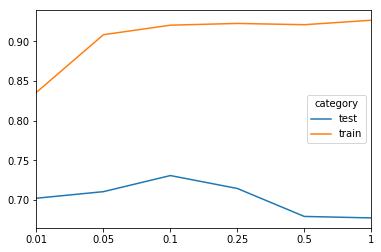

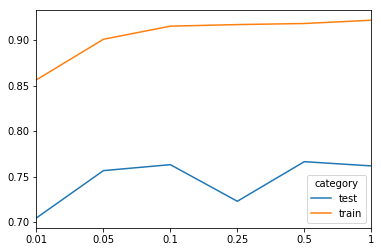

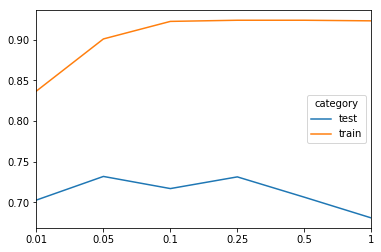

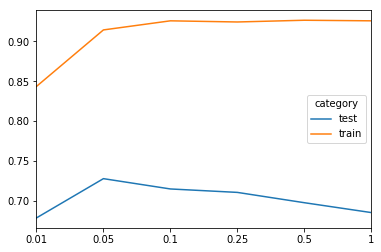

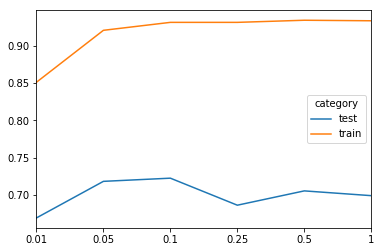

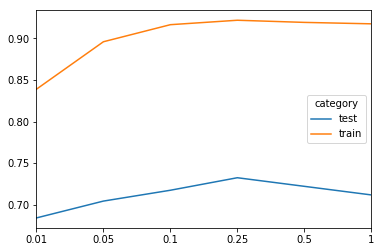

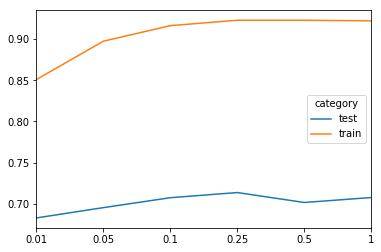

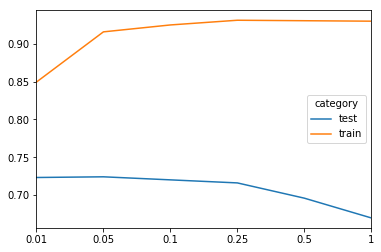

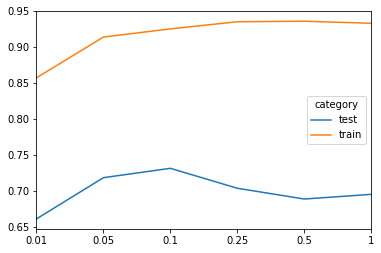

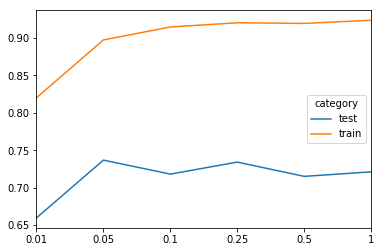

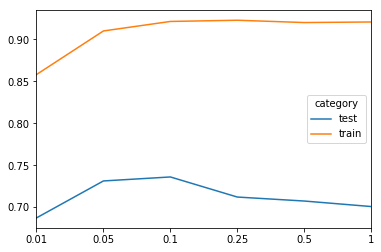

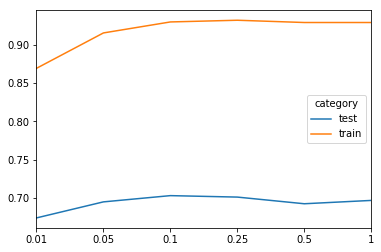

In [12]:
for key, grp in df.groupby(['run']):
    grp.groupby(['category']).mean().reset_index().set_index('category').transpose().sort_index().plot.line()

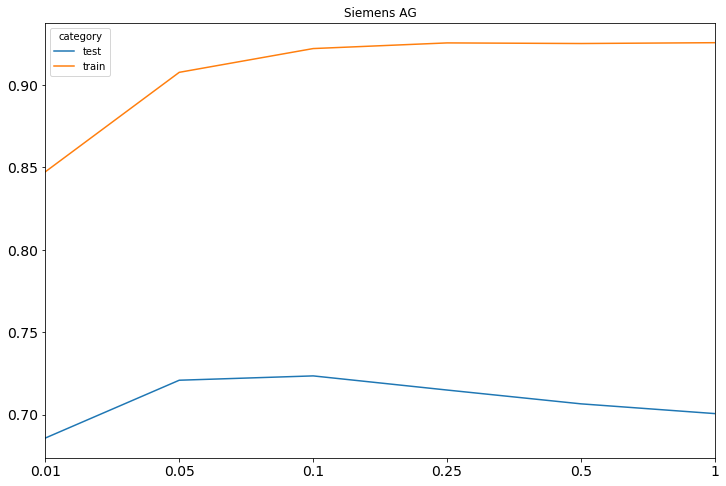

In [13]:
tmpdf = df.groupby(['category']).mean().reset_index().set_index('category').transpose().sort_index()
tmpdf.plot.line(figsize=(12,8), fontsize=14, title=anbieter)

In [14]:
tmpdf

category,test,train
0.01,0.685761,0.847300
0.05,0.720834,0.907651
0.1,0.723462,0.922072
0.25,0.714881,0.925505
0.5,0.706503,0.925135
1,0.700587,0.925638
